https://arxiv.org/pdf/1704.04110.pdf

https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014

https://github.com/awslabs/amazon-sagemaker-examples/blob/master/introduction_to_amazon_algorithms/deepar_electricity/DeepAR-Electricity.ipynb

TODO:

- train/test split
- predict properly

In [1]:
import pandas as pd

d = pd.read_csv('LD2011_2014.txt', sep=';', thousands=',', index_col=0, )
d.index = pd.to_datetime(d.index)
d.shape

(140256, 370)

In [2]:
d.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 00:30:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 00:45:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 01:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 01:15:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0


In [3]:
d = d.resample('H', how='sum')
d.head()

/home/dante/venvs/python36/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  """Entry point for launching an IPython kernel.


,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 01:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 02:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 03:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0
2011-01-01 04:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0.0,0,0,0,0,0,0,0,0


In [4]:
d.shape

(35065, 370)

In [5]:
# hopw many training examples total
import numpy as np
sum(d.apply(lambda s: np.argwhere(s > 0).reshape(-1).max() - np.argwhere(s > 0).reshape(-1).min()))

/home/dante/venvs/python36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


10463878

In [6]:
# all observations are 1 hour intervals
pd.Series(d.index).diff().unique()

array([        'NaT', 3600000000000], dtype='timedelta64[ns]')

In [7]:
for c in d.columns:
    d[c] = d[c].astype(float)
d.dtypes

MT_001    float64
MT_002    float64
MT_003    float64
MT_004    float64
MT_005    float64
           ...   
MT_366    float64
MT_367    float64
MT_368    float64
MT_369    float64
MT_370    float64
Length: 370, dtype: object

In [8]:
d.index.min(), d.index.max()

(Timestamp('2011-01-01 00:00:00'), Timestamp('2015-01-01 00:00:00'))

In [9]:
d.shape

(35065, 370)

In [10]:
d.sum(axis=0)

MT_001    1.899547e+19
MT_002    2.755961e+19
MT_003    2.490666e+19
MT_004    5.058810e+19
MT_005    4.527706e+19
              ...     
MT_366    4.462558e+19
MT_367    5.406011e+19
MT_368    3.381737e+19
MT_369    6.853980e+19
MT_370    1.331800e+19
Length: 370, dtype: float64

In [11]:
d.isnull().any().any()

False

In [12]:
d_train = d[:'2014-09-01']
d_test = d['2014-09-01':]

# feature engineering

In [13]:
import numpy as np


# 7 days of context to predict one day of outcomes
condition_length = 24 * 7
prediction_length = 24


def featurize(s, id):
    name = s.name
    s = drop_padded_values(s)
    df = convert_series_to_frame(s)
    try:
        df = add_categorical_features(df, id)
    except:
        print(id)
    df = add_scaling_factor(df)
    df['name'] = name
    return df

def drop_padded_values(s):
    return np.trim_zeros(s)

def convert_series_to_frame(s):
    return s.to_frame().rename({s.name: 'z'}, axis=1)

def add_categorical_features(df, id):
    df['id'] = id
    df['day_of_week'] = df.index.dayofweek
    df['hour'] = df.index.hour
    df['month'] = df.index.month
    df['week_of_year'] = df.index.weekofyear
    df['age'] = (df.index - df.index.values[0]).total_seconds() / 3600
    return df


# https://stackoverflow.com/questions/6811183/rolling-window-for-1d-arrays-in-numpy/6811241#6811241
def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def add_scaling_factor(df):
    z = df.z.values
    df['scale_factor'] = 0
    df['scale_factor'].iloc[condition_length-1:] = 1 + np.sum(rolling_window(z, condition_length), axis=1)
    return df
    
%time df = pd.concat(featurize(d_train.iloc[:, i], i) for i in range(d_train.shape[-1]))

/home/dante/venvs/python36/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


CPU times: user 5.66 s, sys: 266 ms, total: 5.93 s
Wall time: 5.93 s


In [14]:
rolling_window(np.arange(6), 3).mean(axis=1)

array([1., 2., 3., 4.])

In [15]:
assert df.scale_factor.lt(0).sum() == 0, df.scale_factor.lt(0).sum()

In [16]:
df.scale_factor.hist()

In [17]:
df.scale_factor.min(), df.scale_factor.max(), df.scale_factor.mean()

(0.0, 6.097392389270116e+17, 2.2660472750178237e+17)

In [18]:
max_values = df.groupby('name').age.max().to_dict()
df['scale_factor'] = np.where(df.name.map(max_values) - df.age < prediction_length + 1, 0, df.scale_factor)

In [19]:
df.scale_factor.min(), df.scale_factor.max(), df.scale_factor.mean()

(0.0, 6.097392389270116e+17, 2.2638154803666045e+17)

In [20]:
df['sample_weight'] = df.scale_factor / df.scale_factor.sum()

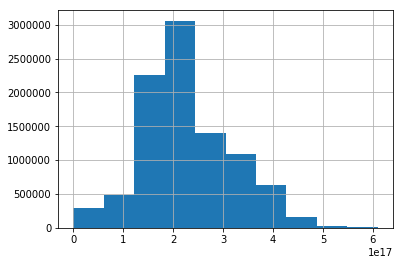

In [21]:
df.scale_factor.hist()

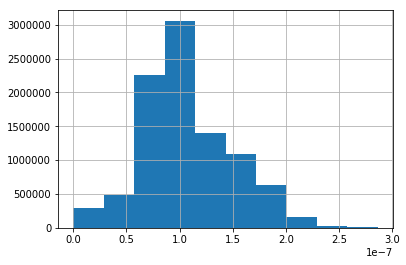

In [22]:
df.sample_weight.hist()

In [23]:
df.head()

,z,id,day_of_week,hour,month,week_of_year,age,scale_factor,name,sample_weight
2012-01-01 00:00:00,8.121827e+14,0,6,0,1,52,0.0,0.0,MT_001,0.0
2012-01-01 01:00:00,1.192893e+15,0,6,1,1,52,1.0,0.0,MT_001,0.0
2012-01-01 02:00:00,1.446701e+15,0,6,2,1,52,2.0,0.0,MT_001,0.0
2012-01-01 03:00:00,8.629442e+14,0,6,3,1,52,3.0,0.0,MT_001,0.0
2012-01-01 04:00:00,5.329949e+14,0,6,4,1,52,4.0,0.0,MT_001,0.0


In [24]:
# (d.iloc[:, 14]).rolling(condition_length).sum().min()

In [25]:
assert (df.scale_factor.eq(0) & df.sample_weight.gt(0)).sum() == 0

# create batch generator

In [26]:
np.random.choice(df.shape[0], p=df.sample_weight)

7775287

In [27]:
df[:condition_length].id.values.reshape((1, -1))

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [28]:
categorical_features = [
    'day_of_week', 'hour', 'month', 'week_of_year', 'age',
]

def format_example(df):
    ids = df.id.values.reshape((1, -1))
    z = df.z.values.reshape((1, -1, 1))
    x = df[categorical_features].values[np.newaxis, :, :]
    scale_factor = df.scale_factor.iloc[condition_length-1:condition_length].values.reshape((1, 1, 1))
    assert scale_factor == (1 + z[:, :condition_length, :].sum(axis=1)), scale_factor
    
    return {
        'id_condition': ids[:, :condition_length],
        'id_prediction': ids[:, condition_length:condition_length+prediction_length],
        'x_condition': x[:, :condition_length, :],
        'x_prediction': x[:, condition_length:condition_length+prediction_length, :],
        'z_condition': z[:, :condition_length, :],
        'z_prediction': z[:, condition_length:condition_length+prediction_length, :],
        'scale_factor': scale_factor
    }, z[:, condition_length+1:condition_length+prediction_length+1, :]

def get_training_example(df, i):
    start = i - condition_length
    stop = i + prediction_length + 1
    return df.iloc[start:stop]

def make_examples(df, indices):
    examples = []
    for i in indices:
        try:
            examples.append(format_example(get_training_example(df, i)))
        except AssertionError as err:
            print('skipping', i, err.args)
    return examples

def make_batch(examples):
    keys = examples[0][0].keys()
    x = {k: np.concatenate([t[0][k] for t in examples]) for k in keys}
    y = np.concatenate([t[1] for t in examples])
    return x, y

In [29]:
get_training_example(df, 1000).shape, condition_length + prediction_length + 1

((193, 10), 193)

In [30]:
x_e, y_e = format_example(df.iloc[:condition_length+prediction_length+1])

In [31]:
assert (x_e['z_prediction'][:, 1:, :] == y_e[:, :-1, :]).all(), 'predictions not offset correctly'

In [32]:
examples = make_examples(df, np.arange(64) + 1000)
%time x_batch, y_batch = make_batch(examples)

CPU times: user 267 µs, sys: 45 µs, total: 312 µs
Wall time: 315 µs


In [33]:
{k: v.shape for k, v in x_batch.items()}, y_batch.shape

({'id_condition': (64, 168),
  'id_prediction': (64, 24),
  'x_condition': (64, 168, 5),
  'x_prediction': (64, 24, 5),
  'z_condition': (64, 168, 1),
  'z_prediction': (64, 24, 1),
  'scale_factor': (64, 1, 1)},
 (64, 24, 1))

# model

In [34]:
import math
import tensorflow as tf

tf.keras.backend.set_floatx('float64')
pi = tf.constant(math.pi, dtype='float64')
epsilon = tf.constant(1e-9, dtype='float64')

def guassian_likelihood(z, model_outputs):
    mu, sigma = model_outputs[:, :, 0], model_outputs[:, :, 1]
    # need to keep three dimensions when we slice here
    mu, sigma = tf.keras.backend.expand_dims(mu), tf.keras.backend.expand_dims(sigma)
    return (1. / tf.math.sqrt(2 * pi * sigma ** 2)) * tf.exp(-1 * (((z - mu) ** 2) / ((2 * sigma ** 2))))


def guassian_log_likelihood_loss(z, model_outputs):
    return -tf.math.log(guassian_likelihood(z, model_outputs) + epsilon)


def _make_inputs(condition_length, prediction_length, time_cat_dims):
    id_condition = tf.keras.Input((condition_length,), name='id_condition')
    id_prediction = tf.keras.Input((prediction_length,), name='id_prediction')

    x_condition_input = tf.keras.Input((condition_length, time_cat_dims), name='x_condition')
    x_prediction_input = tf.keras.Input((prediction_length, time_cat_dims), name='x_prediction')
    
    z_condition_input = tf.keras.Input((condition_length, 1), name='z_condition')
    z_prediction_input = tf.keras.Input((prediction_length, 1), name='z_prediction')
    
    scale_factor_input = tf.keras.Input((1, 1), name='scale_factor')
    
    return id_condition, id_prediction, x_condition_input, x_prediction_input, z_condition_input, z_prediction_input, scale_factor_input


def _make_encoder_decoder(encoder_inputs, decoder_inputs, lstm_layers, lstm_units):
    # make encoder first
    encoder_outputs = encoder_inputs
    for i in range(lstm_layers):
        encoder = tf.keras.layers.LSTM(lstm_units, return_state=True, return_sequences=True,
                                       unit_forget_bias=1.0,  # this is the default, but explicitly mentioned in the paper
                                       name=f'encoder_{i}')
        encoder_outputs, *encoder_state  = encoder(encoder_outputs)

    # now make decoder, sharing encoder state on the first layer
    decoder_outputs = decoder_inputs
    for i in range(lstm_layers):
        decoder = tf.keras.layers.LSTM(lstm_units, return_sequences=True,
                                       unit_forget_bias=1.0,  # this is the default, but explicitly mentioned in the paper
                                       name=f'decoder_{i}')
        if i == 0:
            decoder_outputs = decoder(decoder_outputs, initial_state=encoder_state)
        else:
            decoder_outputs = decoder(decoder_outputs)
    return decoder_outputs

def _make_distribution_params(sequences, scale, W_mu_activation, W_sigma_activation):
    mu = tf.keras.layers.Dense(1, activation=W_mu_activation)(sequences)
    sigma = tf.keras.layers.Dense(1, activation=W_sigma_activation)(sequences)
    
#     mu = tf.keras.layers.Multiply()([mu, scale])
#     sigma = tf.keras.layers.Multiply()([sigma, 1 / tf.math.sqrt(scale)])

    return tf.keras.layers.Concatenate()([mu, sigma])
        

def DeepAR(condition_length, prediction_length, time_cat_dims, item_input_embedding_dim=370, item_output_embedding_dim=20,
           lstm_layers=3, lstm_units=40, W_mu_activation='linear', W_sigma_activaton='softplus'):

    id_condition, id_prediction, x_condition_input, x_prediction_input, z_condition_input, z_prediction_input, scale_factor = \
        _make_inputs(condition_length, prediction_length, time_cat_dims)

    condition_embedding = tf.keras.layers.Embedding(output_dim=item_output_embedding_dim, input_dim=item_input_embedding_dim,
                                                    input_length=condition_length)(id_condition)
    prediction_embedding = tf.keras.layers.Embedding(output_dim=item_output_embedding_dim, input_dim=item_input_embedding_dim,
                                                     input_length=prediction_length)(id_prediction)
    condition_inputs = tf.keras.layers.Concatenate()([
        tf.keras.layers.BatchNormalization(trainable=False)(x_condition_input),
        z_condition_input,
        condition_embedding])
    prediction_inputs = tf.keras.layers.Concatenate()([
        tf.keras.layers.BatchNormalization(trainable=False)(x_prediction_input),
        z_prediction_input,
        prediction_embedding])

    decoder_outputs = _make_encoder_decoder(condition_inputs, prediction_inputs, lstm_layers, lstm_units)

    z_distribution_params = _make_distribution_params(decoder_outputs, scale_factor, W_mu_activation, W_sigma_activaton)

    return tf.keras.models.Model(
        inputs=[
            scale_factor,
            id_condition, id_prediction,
            x_condition_input, x_prediction_input,
            z_condition_input, z_prediction_input],
        outputs=[z_distribution_params])

tf.keras.backend.set_floatx('float64')
model = DeepAR(condition_length, prediction_length, len(categorical_features), lstm_layers=3)
adam = tf.keras.optimizers.Adam(learning_rate=.0005)
model.compile(loss=guassian_log_likelihood_loss, optimizer=adam)

In [35]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
x_condition (InputLayer)        [(None, 168, 5)]     0                                            
__________________________________________________________________________________________________
id_condition (InputLayer)       [(None, 168)]        0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 168, 5)       20          x_condition[0][0]                
__________________________________________________________________________________________________
z_condition (InputLayer)        [(None, 168, 1)]     0                                            
______________________________________________________________________________________________

In [36]:
n_total_training_examples = 500000
n_steps_per_epoch = 500
n_epochs = 15
batch_size = 64
indices = np.random.choice(df.shape[0], size=n_total_training_examples, p=df.sample_weight)
%time examples = make_examples(df, indices)

skipping 5403897 (array([[[0.]]]),)
skipping 7225113 (array([[[0.]]]),)
skipping 3034155 (array([[[0.]]]),)
skipping 2083105 (array([[[0.]]]),)
skipping 7418073 (array([[[0.]]]),)
skipping 8553668 (array([[[0.]]]),)
skipping 5403897 (array([[[0.]]]),)
skipping 532568 (array([[[0.]]]),)
skipping 8910140 (array([[[0.]]]),)
skipping 1437419 (array([[[0.]]]),)
skipping 8255217 (array([[[0.]]]),)
skipping 4317027 (array([[[0.]]]),)
skipping 2677537 (array([[[0.]]]),)
skipping 835934 (array([[[0.]]]),)
skipping 5371737 (array([[[0.]]]),)
skipping 7121985 (array([[[0.]]]),)
skipping 1437419 (array([[[0.]]]),)
skipping 8933540 (array([[[0.]]]),)
skipping 5757657 (array([[[0.]]]),)
skipping 602768 (array([[[0.]]]),)
CPU times: user 11min 47s, sys: 5.24 s, total: 11min 52s
Wall time: 12min 12s


In [35]:
skipped = [0]
def gen(examples, batch_size):
    while True:
        np.random.shuffle(examples)
        for i in range(len(examples) // batch_size):
            try:
                x_batch, y_batch = make_batch(examples[i*batch_size:(i+1)*batch_size])
                scale_factor = x_batch['scale_factor']
                if (scale_factor == 0).any():  # this shouldn't happen, just being cautious
                    skipped[0] += 1
                    continue
                x_batch['z_condition'] = x_batch['z_condition'] / scale_factor
                x_batch['z_prediction'] = x_batch['z_prediction'] / scale_factor
                y_batch = y_batch / scale_factor
                yield x_batch, y_batch
            except Exception:
                pass

In [38]:
g = gen(examples, batch_size)
%time x_test, y_test = next(g)  # TODO: not true test cases

CPU times: user 96.5 ms, sys: 48.2 ms, total: 145 ms
Wall time: 2.29 s


In [39]:
callbacks = model.fit(
    gen(examples, batch_size),
    steps_per_epoch=n_total_training_examples // batch_size,
    epochs=n_epochs)

Train for 7812 steps
Epoch 1/15
7812/7812 [==============================] - 1597s 204ms/step - loss: -3.9466
Epoch 2/15
7812/7812 [==============================] - 961s 123ms/step - loss: -4.2134
Epoch 3/15
7812/7812 [==============================] - 894s 115ms/step - loss: -4.2333
Epoch 4/15
7812/7812 [==============================] - 863s 110ms/step - loss: -4.2475
Epoch 5/15
7812/7812 [==============================] - 892s 114ms/step - loss: -4.3214
Epoch 6/15
7812/7812 [==============================] - 873s 112ms/step - loss: -4.3675
Epoch 7/15
7812/7812 [==============================] - 866s 111ms/step - loss: -4.3810
Epoch 8/15
7812/7812 [==============================] - 882s 113ms/step - loss: -4.4255
Epoch 9/15
7812/7812 [==============================] - 868s 111ms/step - loss: -4.4668
Epoch 10/15
7812/7812 [==============================] - 872s 112ms/step - loss: -4.5028
Epoch 11/15
7812/7812 [==============================] - 879s 112ms/step - loss: -4.5215
Epoch 12

In [73]:
x_test, y_test = next(gen(examples, 64))   # TODO: not true test cases
%time p = model.predict(x_test)

CPU times: user 109 ms, sys: 12.5 ms, total: 121 ms
Wall time: 102 ms


<ErrorbarContainer object of 3 artists>

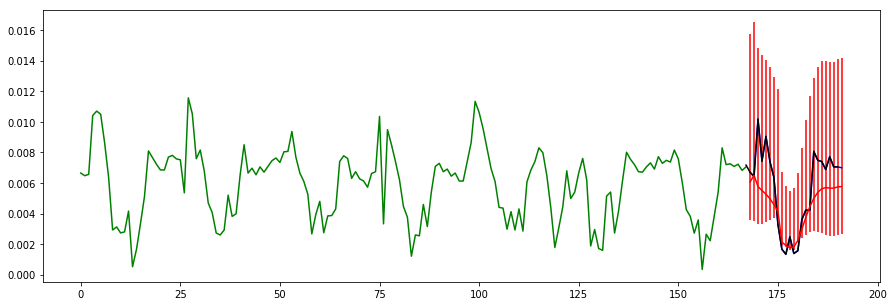

In [60]:
import scipy.stats as ss
import matplotlib.pyplot as plt

i = np.random.randint(len(p))

params_it = p[i]
dist_it = ss.norm(params_it[:, 0], params_it[:, 1])
mean_it = dist_it.mean()
low_it = dist_it.ppf(0.1)
high_it = dist_it.ppf(0.9)
y_it = y_test[i].reshape(-1)
n = y_test.shape[-2]

fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(np.arange(n) + condition_length, y_it, color='b')
# plt.errorbar(np.arange(n), mean_it, color='r')
plt.plot(np.arange(condition_length), x_test['z_condition'][i].reshape(-1), color='g')
plt.plot(np.arange(prediction_length) + condition_length - 1, x_test['z_prediction'][i].reshape(-1), color='k')

plt.errorbar(np.arange(n) + condition_length, mean_it, color='r', yerr=[np.abs(low_it), high_it])
# plt.plot(np.arange(n), low_it)
# plt.plot(np.arange(n), high_it)

In [42]:
y_it, x_test['z_prediction'][i].reshape(-1)

(array([0.00909025, 0.00734516, 0.00612261, 0.00396343, 0.00571838,
        0.00750291, 0.00194228, 0.00470288, 0.00834095, 0.00833109,
        0.01321143, 0.00999731, 0.01012548, 0.01020435, 0.003293  ,
        0.0075739 , 0.0106283 , 0.00394371, 0.0017096 , 0.00082522,
        0.00763207, 0.00402259, 0.00358878, 0.01030295]),
 array([0.00678318, 0.00909025, 0.00734516, 0.00612261, 0.00396343,
        0.00571838, 0.00750291, 0.00194228, 0.00470288, 0.00834095,
        0.00833109, 0.01321143, 0.00999731, 0.01012548, 0.01020435,
        0.003293  , 0.0075739 , 0.0106283 , 0.00394371, 0.0017096 ,
        0.00082522, 0.00763207, 0.00402259, 0.00358878]))

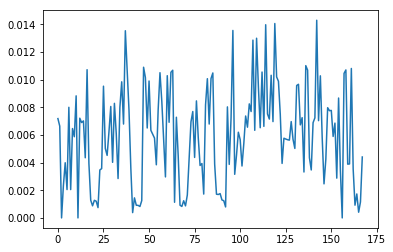

In [43]:
plt.plot(np.arange(condition_length), x_test['z_condition'][i].reshape(-1))

In [44]:
model.save('model.h5')

# Predict on held out set

In [37]:
model = tf.keras.models.load_model('model.h5', custom_objects={'guassian_log_likelihood_loss': guassian_log_likelihood_loss})

In [51]:
df_test = pd.concat(featurize(d_test.iloc[:, i], i) for i in range(d_test.shape[-1]) if not i == 222)
df_test['sample_weight'] = df_test.scale_factor / df_test.scale_factor.sum()
indices = np.random.choice(df_test.shape[0], size=10)#, p=df_test.sample_weight)
test_examples = make_examples(df_test, indices)

/home/dante/venvs/python36/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


skipping 837818 (array([[[0.]]]),)


In [52]:
x_test, y_test = make_batch(test_examples)
x_test['z_condition'] = x_test['z_condition'] / x_test['scale_factor']
y_test = y_test / x_test['scale_factor']

In [57]:
import scipy.stats as ss

def predict(model, x):
    x = {k: v for k, v in x.items()}
    B, T, _ = x['x_prediction'].shape
    x['z_prediction'] = np.zeros((B, T, 1))
    for i in range(T):
        p = model.predict(x)
        z_hat = ss.norm(p[:, i, 0], p[:, i, 1]).rvs()
        x['z_prediction'][:, i, 0] = z_hat
    return x['z_prediction']

In [58]:
# x_test, y_test = next(gen(examples, 10))   # TODO: not true test cases

In [59]:
%%time
predictions = []
for _ in range(30):
    predictions.append(predict(model, x_test))

CPU times: user 1min 35s, sys: 2.29 s, total: 1min 38s
Wall time: 1min 26s


In [65]:
p_means = np.stack(predictions, axis=3).mean(axis=(2, 3))
p_means.shape

(9, 24)

Text(0.5,0,'Time ($t$)')

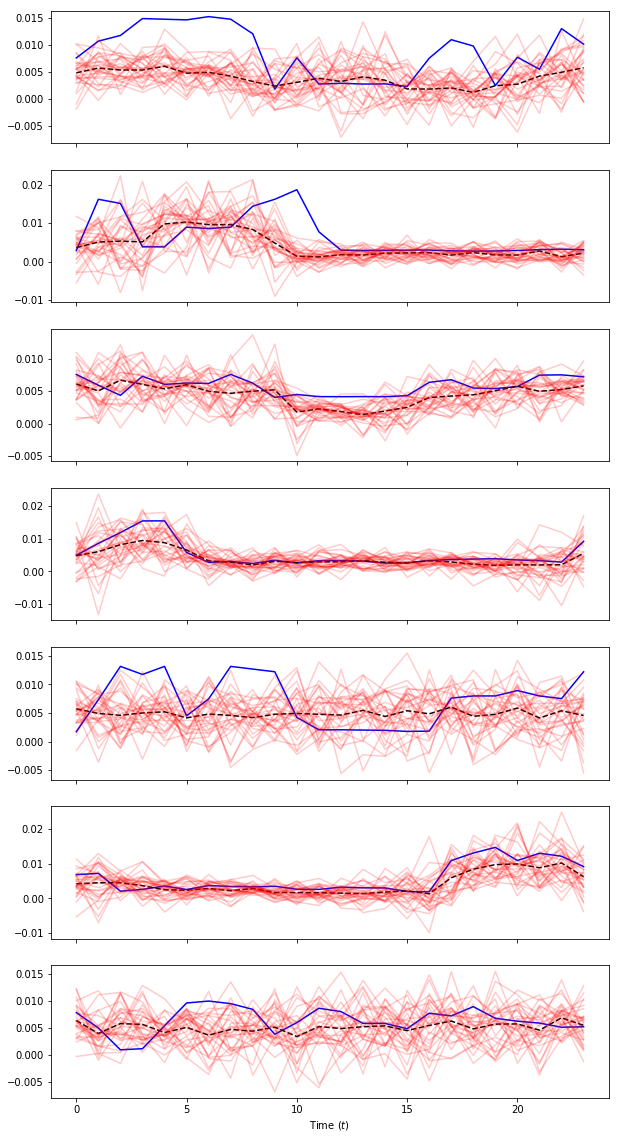

In [71]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(x_test), figsize=(10, 20), sharex=True)


for i, ax in enumerate(axs):
    ax.plot(np.arange(prediction_length), y_test[i].reshape(-1), color='b')
    ax.plot(np.arange(prediction_length), p_means[i], color='k', ls='--')
    for p_new in predictions:
        ax.plot(np.arange(prediction_length), p_new[i].reshape(-1), color='r', alpha=0.2)

ax.set_xlabel('Time ($t$)')

Text(0.5,0,'Time ($t$)')

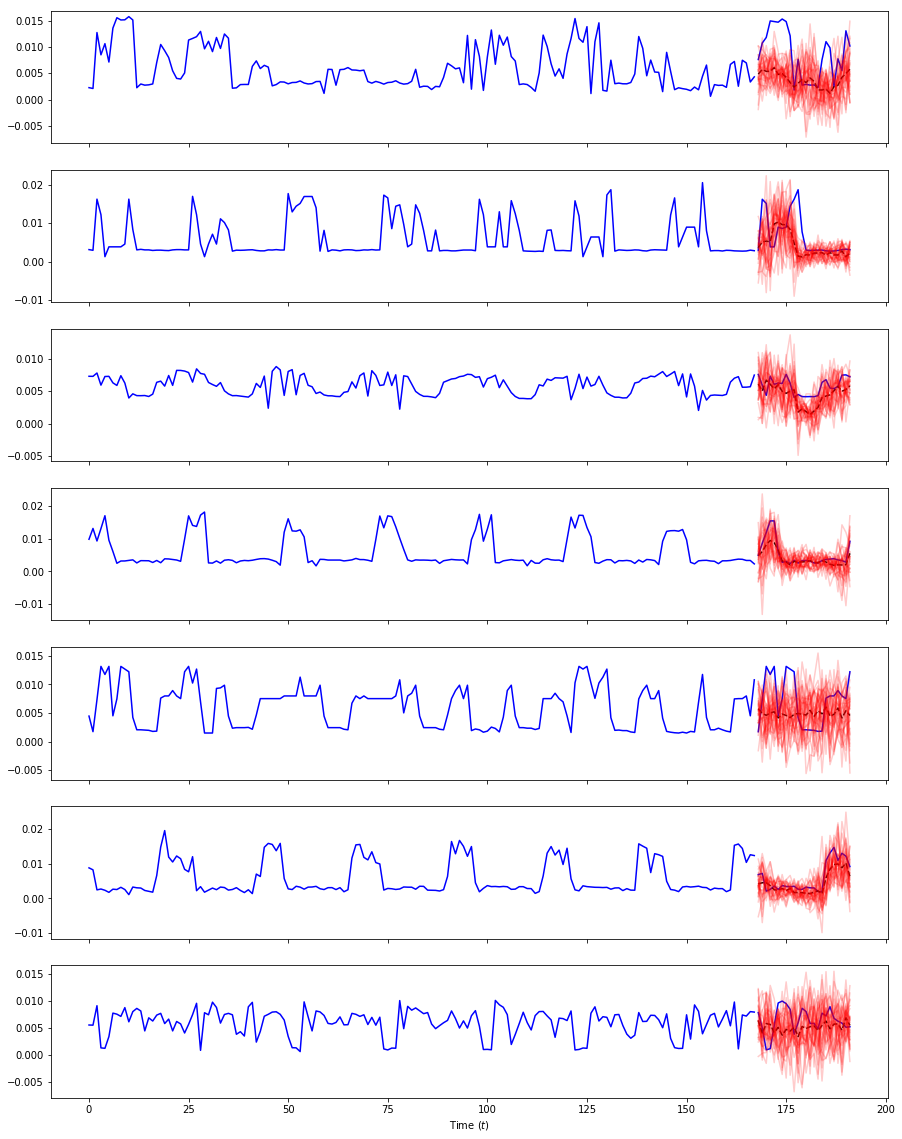

In [77]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(x_test), figsize=(15, 20), sharex=True)


for i, ax in enumerate(axs):
    ax.plot(np.arange(condition_length), x_test['z_condition'][i].reshape(-1), color='b')
    ax.plot(condition_length + np.arange(prediction_length), y_test[i].reshape(-1), color='b')
    ax.plot(condition_length + np.arange(prediction_length), p_means[i], color='k', ls='--')
    for p_new in predictions:
        ax.plot(condition_length + np.arange(prediction_length), p_new[i].reshape(-1), color='r', alpha=0.2)

ax.set_xlabel('Time ($t$)')